PROJET SCOLAIRE - THEORIE DES GRAPHES
============================================================

I. Configuration de l'environement

In [44]:
# Importations
!pip install networkx matplotlib numpy pandas -q
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import FancyBboxPatch, Circle
import warnings

# Parametrage pour l'affichage
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

II. Modelisation mathematique

In [47]:
# Informations sur les lycées
lycees_info = {
    'L0': {'nom': 'Serveur central', 'distance_centre': 0, 'eleves': 0},
    'L1': {'nom': 'Lycée Bogodogo', 'distance_centre': 3, 'eleves': 2500},
    'L2': {'nom': 'Lycée Zinda', 'distance_centre': 4, 'eleves': 3000},
    'L3': {'nom': 'Lycée Mandela', 'distance_centre': 6, 'eleves': 2000},
    'L4': {'nom': 'Lycée Municipal', 'distance_centre': 2, 'eleves': 1800},
    'L5': {'nom': 'Lycée Scientifique', 'distance_centre': 8, 'eleves': 1200},
    'L6': {'nom': 'Lycée Mixte', 'distance_centre': 5, 'eleves': 2200}
}

In [48]:
# Matrice de distances complète (7x7)
labels = ['L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6']
distance_matrix = np.array([
    [0, 3, 4, 6, 2, 8, 5],  # L0
    [3, 0, 3, 5, 4, 2, 7],  # L1
    [4, 3, 0, 2, 3, 4, 6],  # L2
    [6, 5, 2, 0, 3, 5, 4],  # L3
    [2, 4, 3, 3, 0, 3, 5],  # L4
    [8, 2, 4, 5, 3, 0, 6],  # L5
    [5, 7, 6, 4, 5, 6, 0]   # L6
])

In [51]:
# Affichage de la matrice de distances
print("\n Matrice de Distances (km): \n")
df_distances = pd.DataFrame(distance_matrix, index=labels, columns=labels)
print(df_distances)


 Matrice de Distances (km): 

    L0  L1  L2  L3  L4  L5  L6
L0   0   3   4   6   2   8   5
L1   3   0   3   5   4   2   7
L2   4   3   0   2   3   4   6
L3   6   5   2   0   3   5   4
L4   2   4   3   3   0   3   5
L5   8   2   4   5   3   0   6
L6   5   7   6   4   5   6   0


In [52]:
# Coûts
COUT_FIBRE_PAR_KM = 500000  # FCFA
COUT_RADIO_PAIRE = 2000000  # FCFA
SEUIL_RADIO = 5  # km

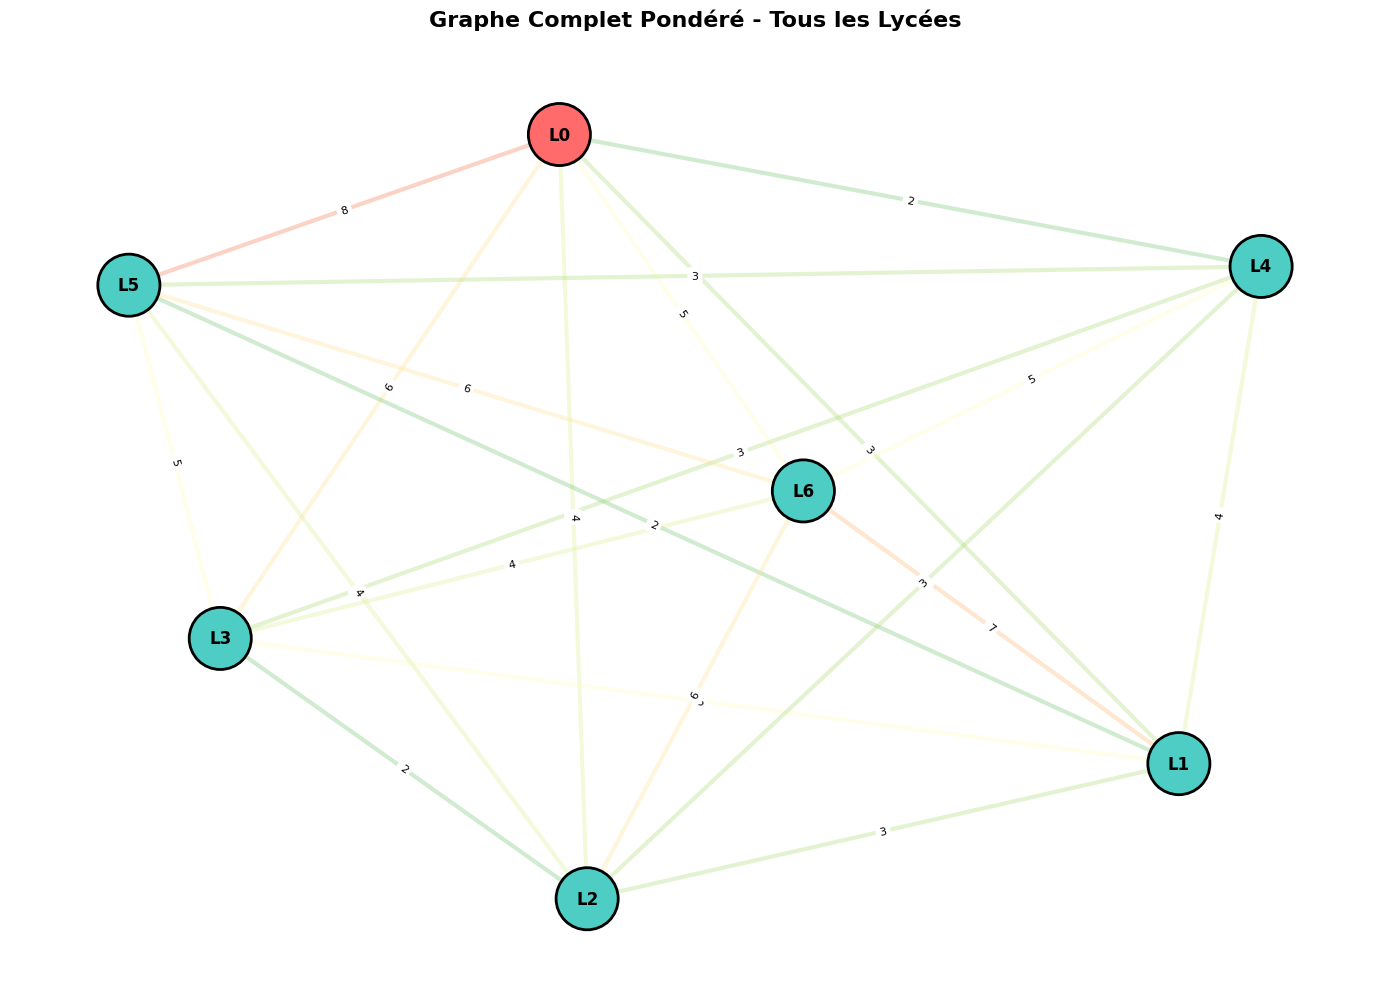

In [65]:
# Créer le graphe complet
G_complet = nx.Graph()
for i, node in enumerate(labels):
    G_complet.add_node(node, nom=lycees_info[node]['nom'])
    
# Ajouter toutes les arêtes avec leurs distances
aretes_completes = []
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        distance = distance_matrix[i][j]
        G_complet.add_edge(labels[i], labels[j], weight=distance)
        aretes_completes.append((labels[i], labels[j], distance))

# Visualisation du graphe complet
fig, ax = plt.subplots(figsize=(14, 10))
pos = nx.spring_layout(G_complet, seed=42, k=2)

# Dessiner les arêtes avec couleurs selon distance
edges = G_complet.edges()
weights = [G_complet[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(G_complet, pos, width=3, alpha=0.3, edge_color=weights, 
edge_cmap=plt.cm.RdYlGn_r, edge_vmin=0, edge_vmax=10)

# Dessiner les nœuds
nx.draw_networkx_nodes(G_complet, pos, node_size=2000, 
node_color=['#FF6B6B' if n=='L0' else '#4ECDC4' for n in G_complet.nodes()],
edgecolors='black', linewidths=2)
# Labels des nœuds
nx.draw_networkx_labels(G_complet, pos, font_size=12, font_weight='bold')

# Labels des arêtes (distances)
edge_labels = nx.get_edge_attributes(G_complet, 'weight')
nx.draw_networkx_edge_labels(G_complet, pos, edge_labels, font_size=8)

plt.title("Graphe Complet Pondéré - Tous les Lycées", fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

III. Algorithme de Kruskal

In [68]:
def kruskal(Graphe):
    # Récupération des arêtes
    aretes = [(u, v, data['weight']) for u, v, data in Graphe.edges(data=True)]

    # Initialisation Union-Find
    parent = {n: n for n in Graphe.nodes()}
    mst = []

    def trouver(x):
        if parent[x] != x:
            parent[x] = trouver(parent[x])
        return parent[x]

    def union(x, y):
        parent[trouver(x)] = trouver(y)

    # Tri des arêtes par poids
    aretes.sort(key=lambda x: x[2])

    # Kruskal
    for u, v, poids in aretes:
        if trouver(u) != trouver(v):
            mst.append((u, v, poids))
            union(u, v)

    return mst


 Arêtes de l'Arbre Couvrant de Minimal :
   1. L0-L4: 2 km
   2. L1-L5: 2 km
   3. L2-L3: 2 km
   4. L0-L1: 3 km
   5. L1-L2: 3 km
   6. L3-L6: 4 km

 Distance totale: 16 km


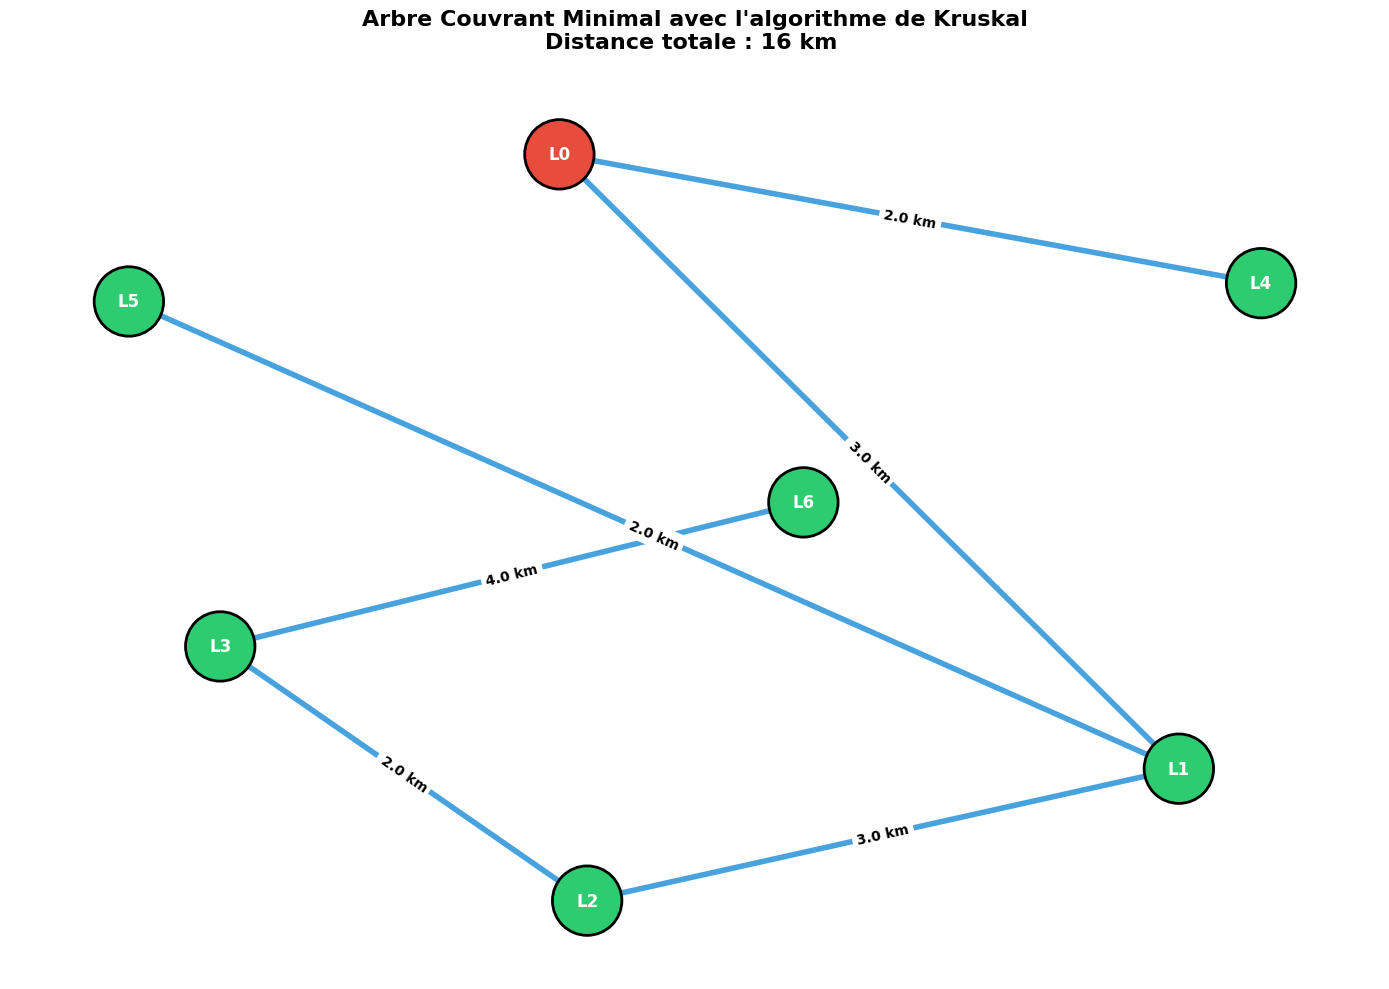

In [78]:
# ================================
# Données ACM depuis Kruskal
# ================================
acm_edges = kruskal(G_complet)   # résultat de kruskal(Graphe)

# Calculs
distance_totale_acm = sum(d for _, _, d in acm_edges)

print(f"\n Arêtes de l'Arbre Couvrant de Minimal :")
for i, (u, v, d) in enumerate(acm_edges, 1):
    print(f"   {i}. {u}-{v}: {d} km")

print(f"\n Distance totale: {distance_totale_acm} km")

# ================================
# Création du graphe ACM
# ================================
G_acm = nx.Graph()

# Ajouter les nœuds
for node in G_complet.nodes():
    G_acm.add_node(node)

# Ajouter les arêtes de l’ACM
for u, v, d in acm_edges:
    G_acm.add_edge(u, v, weight=d)


# ================================
# Visualisation de l'ACM
# ================================
fig, ax = plt.subplots(figsize=(14, 10))

# 👉 Astuce : garder la même disposition que le graphe complet
pos_acm = nx.spring_layout(G_complet, seed=42, k=2)

# Dessiner les arêtes
nx.draw_networkx_edges(
    G_acm, pos_acm,
    width=4,
    alpha=0.9,
    edge_color='#3498db'
)

# Dessiner les nœuds
nx.draw_networkx_nodes(
    G_acm, pos_acm,
    node_size=2500,
    node_color=['#e74c3c' if n == 'L0' else '#2ecc71' for n in G_acm.nodes()],
    edgecolors='black',
    linewidths=2
)

# Labels des nœuds
nx.draw_networkx_labels(
    G_acm, pos_acm,
    font_size=12,
    font_weight='bold',
    font_color='white'
)

# Labels des arêtes
edge_labels_acm = {
    (u, v): f"{d:.1f} km" for u, v, d in acm_edges
}
nx.draw_networkx_edge_labels(
    G_acm, pos_acm,
    edge_labels_acm,
    font_size=10,
    font_weight='bold'
)

# Titre
plt.title(
    f"Arbre Couvrant Minimal avec l'algorithme de Kruskal\n"
    f"Distance totale : {distance_totale_acm} km ",
    fontsize=16,
    fontweight='bold',
    pad=20
)

plt.axis('off')
plt.tight_layout()
plt.show()

In [36]:
# Matrice d'adjacence de l'ACM
adj_matrix_acm = nx.to_numpy_array(G_acm, nodelist=labels, weight=None)
df_adj_acm = pd.DataFrame(adj_matrix_acm, index=labels, columns=labels, dtype=int)
print("\n📊 Matrice d'Adjacence de l'ACM:")
print(df_adj_acm)


📊 Matrice d'Adjacence de l'ACM:
    L0  L1  L2  L3  L4  L5  L6
L0   0   0   0   0   0   0   0
L1   0   0   0   0   0   0   0
L2   0   0   0   0   0   0   0
L3   0   0   0   0   0   0   0
L4   0   0   0   0   0   0   0
L5   0   0   0   0   0   0   0
L6   0   0   0   0   0   0   0
